In [8]:
%load_ext autoreload
%autoreload 2
from Environment import Environment
from LoadBalancer import LoadBalancer
from Source import Source, ArrivalSchedule

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Running simple simulation
- 10 servers fixed
- 14 arrivals per second
- time limit 10

In [2]:
stopTime = 10*60*60
env = Environment(stopTime=stopTime)

loadBalancer = LoadBalancer(nServers=10, environment=env)

requestTypes = [(0.5,1,0.1,10), (0.5,2,0.2,10)] #(prob, mu, sigma, cancelTime)
arrivalsPerSecond = 14
source = Source(arrivalsPerSecond, requestTypes, loadBalancer, env)

env.run(debug=False, showProgress=False)

## Checking results

Benefit of running the system: 83674.00000000297


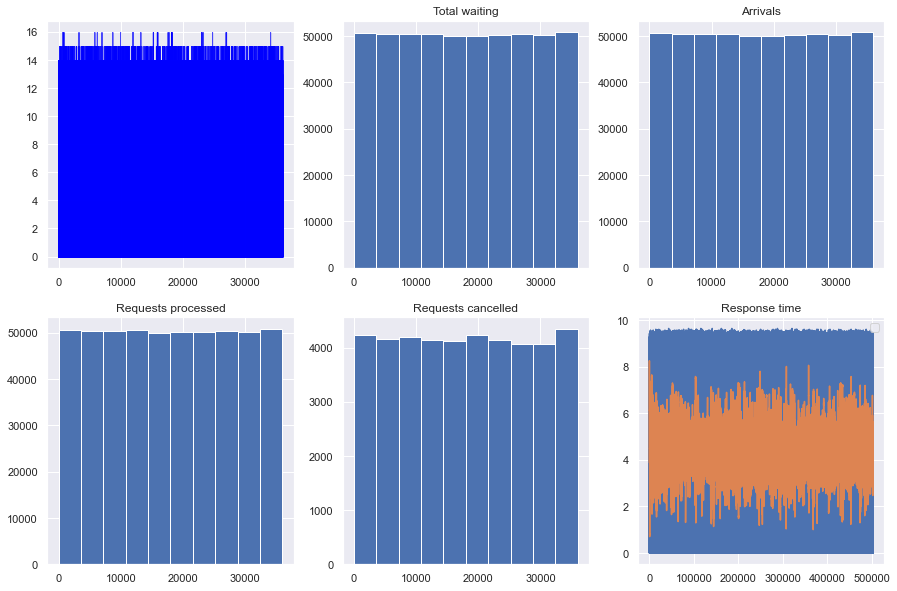

In [3]:
def plotSimulationSummary(environment: Environment, nServers=3):
    processCost = 1
    cancelCost = -10
    serverCost = -100

    nCancelled = len(environment.log['requestCancelled']) if 'requestCancelled' in environment.log.keys() else 0
    cost = len(environment.log['requestProcessed']) *processCost + nCancelled * cancelCost + nServers*env.currentTime/60/60*serverCost
    print(f"Benefit of running the system: {cost}")
    queueSizeKeys = [key for key in environment.log.keys() if 'queueSize' in key]

    fig, axs = plt.subplots(2,3, figsize=(15,10))
    axs_flat = axs.flatten()

    for key in queueSizeKeys:
         axs_flat[0].fill_between(environment.logTime[key], environment.log[key], alpha=0.7, color='blue')
        
    plt.legend(labels=[key.strip("queueSize_") for key in queueSizeKeys])

    axs_flat[1].hist(environment.logTime["requestStartWaiting"])
    axs_flat[1].set_title("Total waiting")

    axs_flat[2].hist(environment.logTime["arrivalEvent"])
    axs_flat[2].set_title("Arrivals")

    axs_flat[3].hist(environment.logTime["requestProcessed"])
    axs_flat[3].set_title("Requests processed")

    if 'requestCancelled' in environment.log.keys():
        axs_flat[4].hist(environment.logTime["requestCancelled"])
        axs_flat[4].set_title("Requests cancelled")

    axs_flat[5].plot(environment.log["requestWaitingTime"])
    rolling = pd.Series(index=environment.logTime["requestWaitingTime"], data=environment.log["requestWaitingTime"]).rolling(100).mean()
    axs_flat[5].plot(rolling.values)
    axs_flat[5].set_title("Response time")

plotSimulationSummary(environment=env)


## Time varying arrivals

In [9]:
stopTime = 12*60*60
env = Environment(stopTime=stopTime)

loadBalancer = LoadBalancer(nServers=3, environment=env)

requestTypes = [(0.5,1,0.1,10), (0.5,2,0.2,10)] #(prob, mu, sigma, cancelTime)
arrivalsPerSecond = 14
source = Source(arrivalsPerSecond, requestTypes, loadBalancer, env)

schedule = [11,12,14,16,14,12,13,15,17,16,14,12] #12 periods
periodLength = 0.5*60*60 #half an hour per period -> schedule repeated two times in 12 hours
arrivalSchedule = ArrivalSchedule(periodLength,arrivalSchedule=schedule, environment=env, loadBalancer=loadBalancer, source=source)
env.run(debug=False)

Benefit of running the system: -241643.0


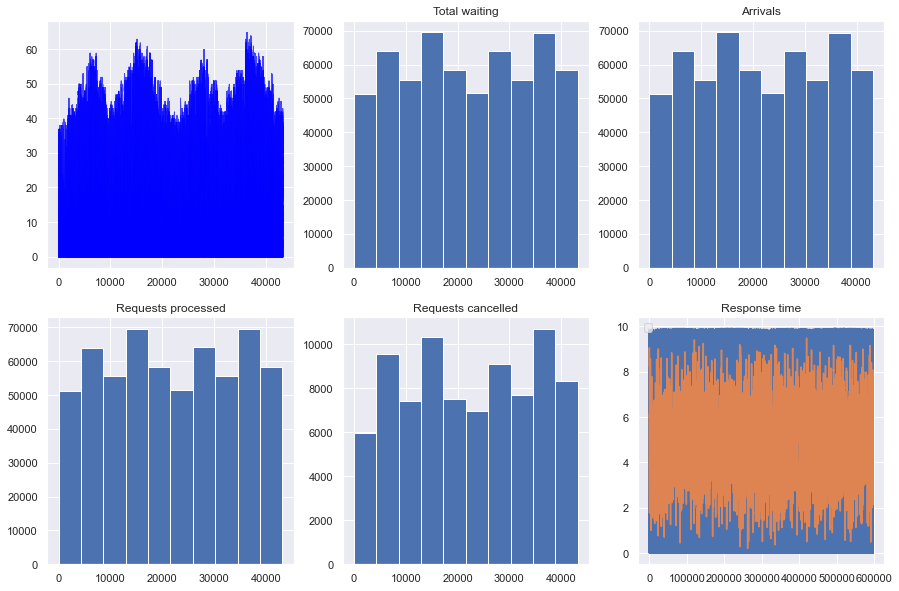

In [10]:
plotSimulationSummary(environment=env)

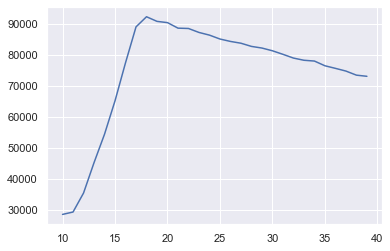

In [14]:
##ignore
stopTime = 3*60*60
samplingInterval = 0.05
profit = []
requestTypes = [(0.5,1,0.1,10), (0.5,2,0.2,10)] #(prob, mu, sigma, cancelTime)
processCost = 1
cancelCost = -10
serverCost = -300
arrivalProb = 0.5
1/samplingInterval * arrivalProb = arrivalsPerSecond/(1/samplingInterval)
nServers = range(10,40)
for n in nServers:
    env = Environment(stopTime=stopTime)
    loadBalancer = LoadBalancer(nServers=n, environment=env)
    source = Source(samplingInterval, arrivalProb, requestTypes, loadBalancer, env)
    env.run(debug=False)
    nCancelled = len(env.log['requestCancelled']) if 'requestCancelled' in env.log.keys() else 0
    cost = len(env.log['requestProcessed']) * processCost + nCancelled * cancelCost + stopTime/60/60*n*serverCost
    profit.append(cost)


plt.plot(nServers, profit)

In [ ]:
def binaryServerSearch(arrivalRate=0.5, searchSpace=[0,20], processCost = 1, cancelCost = -10, serverCost = -300, requestTypes = [(0.5,1,0.1,10), (0.5,2,0.2,10)]):
    

In [15]:
60*60/0.05

72000.0